In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "chicago_taxi_trips" dataset
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# the table name
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

Using Kaggle's public dataset BigQuery integration.
taxi_trips


In [28]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("taxi_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "full" table
df=client.list_rows(table, max_results=5).to_dataframe()
df

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,9c3df104b9df671124f2dfbce23758f86e4c31ef,395a9023e1143e800bfc686ebab1d46536a9490ced5ebc...,2014-10-19 13:45:00+00:00,2014-10-19 14:00:00+00:00,480,1.40,1.703132e+10,1.703128e+10,32,28,...,2.0,8.85,Cash,None,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
1,ded6d5b758085e63861c7c5c785a78340faee13b,0aafa031f499a377150605b9f9c94c933ce52cabc6e43d...,2014-10-28 16:45:00+00:00,2014-10-28 16:45:00+00:00,0,0.00,1.703198e+10,1.703198e+10,76,76,...,1.0,4.25,Cash,None,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.979071,-87.903040,POINT (-87.9030396611 41.9790708201)
2,d099581f82ea9e997eabf46c59969f9d8ab13da4,645fd00c5972cfaf077ed652b9dc82ae67e7e8262d04dd...,2014-12-19 12:00:00+00:00,2014-12-19 12:15:00+00:00,720,2.26,NaN,NaN,32,28,...,0.0,9.25,Cash,None,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
3,de65ee93ff76981a3523688a8929f49578b56e21,d1cb0b38e64d922ac1b61791a9cc03cd203fee1cfbef86...,2014-12-06 18:00:00+00:00,2014-12-06 18:30:00+00:00,1440,2.08,1.703128e+10,1.703108e+10,28,8,...,1.0,14.65,Cash,None,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.909496,-87.630964,POINT (-87.630963601 41.9094956686)
4,506f1779dd608f5b5637f256e5eeba0c8025a79b,7bdac954f2be7f55aa04f12e4be5d954c1d0d42a237bb5...,2014-10-27 09:00:00+00:00,2014-10-27 09:15:00+00:00,540,1.10,1.703128e+10,1.703132e+10,28,32,...,0.0,6.65,Cash,None,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)


## 1. Total number of rides per year from 2013-2023 and analyse with Visualisation

In [29]:
rides_per_year_query = ''' SELECT EXTRACT (YEAR FROM trip_start_timestamp ) as year,
                            COUNT(1) as num_trips
                            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                            GROUP BY year
                            ORDER BY num_trips DESC
                            
                            '''

safeconfig = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

results = client.query(rides_per_year_query, job_config=safeconfig).to_dataframe()
results

,year,num_trips
0,2014,37395079
1,2015,32385527
2,2016,31756403
3,2013,27217300
4,2017,24979611
5,2018,20731105
6,2019,16476440
7,2022,6382071
8,2021,3947677
9,2020,3888831


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


<Axes: xlabel='year', ylabel='num_trips'>

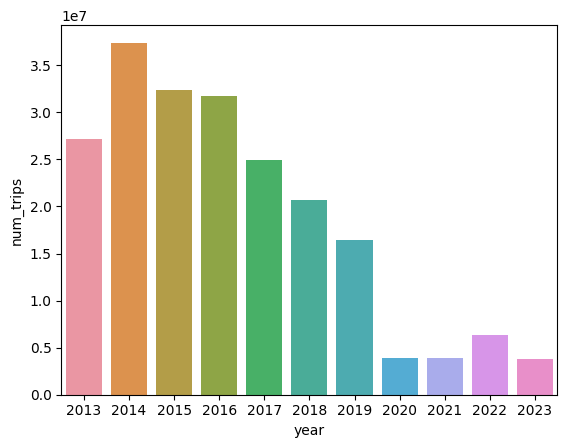

In [31]:
sns.barplot(x='year', y='num_trips', data=results )

Text(0.5, 1.0, 'Number of trips per year')

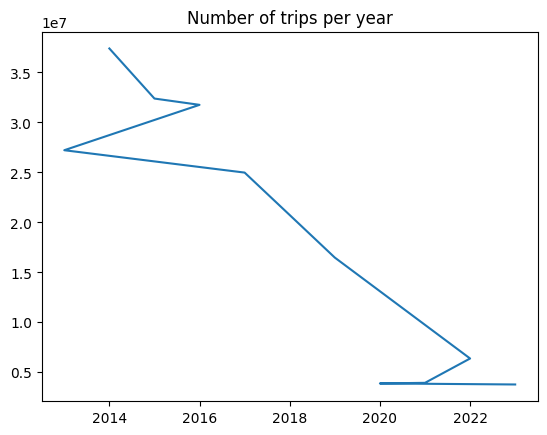

In [32]:
plt.plot('year', 'num_trips', data=results)
plt.title('Number of trips per year')

## 2. The total number of rides accross years for each month

In [33]:
rides_per_month_query = ''' SELECT EXTRACT (YEAR FROM trip_start_timestamp) as year,
                            EXTRACT (MONTH FROM trip_start_timestamp) as month,
                            COUNT(1) as num_trips
                            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                            GROUP BY year, month
                            ORDER BY month
                            
                            '''

safeconfig = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

mresults = client.query(rides_per_month_query, job_config=safeconfig).to_dataframe()

mresults = mresults.sort_values(by='year')
mresults

,year,month,num_trips
21,2013,2,1800259
26,2013,3,2261372
95,2013,9,2342636
4,2013,1,1589863
123,2013,12,2647184
...,...,...,...
19,2023,2,446724
52,2023,5,592701
55,2023,6,625645
1,2023,1,414457


In [34]:
import plotly_express as px
import plotly as plotly
import plotly.io as io
from plotly.subplots import *


In [36]:
print(mresults.groupby('year').value_counts())

year  month  num_trips
2013  1      1589863      1
      2      1800259      1
      12     2647184      1
      11     2529303      1
      10     2569438      1
                         ..
2023  4      570241       1
      3      585160       1
      2      446724       1
      1      414457       1
      8      30           1
Name: count, Length: 128, dtype: int64


Text(0.5, 0, 'Month')

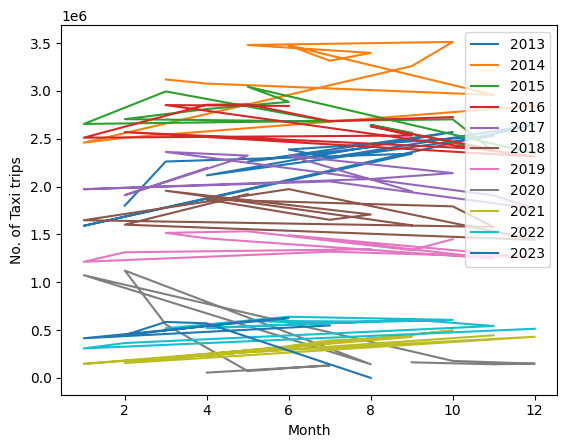

In [37]:
for year in range(2013,2023+1):
    x=mresults[ mresults['year']==year]['month']
    y=mresults[ mresults['year']==year]['num_trips']
    plt.plot(x,y,label=year)

plt.legend(loc='upper right')
plt.ylabel("No. of Taxi trips") 
plt.xlabel("Month")  

In [72]:
ridespermonth = ''' WITH Avarag_Num_trips_per_year AS
                    (
                    Select EXTRACT (DATE FROM trip_start_timestamp) as date,
                    COUNT(1) as num_trips
                    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                    GROUP BY date
                    
                    
                    )
                    SELECT EXTRACT (YEAR FROM date) as year,
                    EXTRACT (MONTH FROM date) as month,
                    AVG(num_trips) as avg_num_trips
                    FROM Avarag_Num_trips_per_year
                    GROUP BY year, month
                    ORDER BY year, month
                            
                            '''

safeconfig = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

rmresults = client.query(ridespermonth, job_config=safeconfig).to_dataframe()

rmresults = rmresults.sort_values(by='month')
rmresults

,year,month,avg_num_trips
0,2013,1,51285.903226
84,2020,1,34622.064516
96,2021,1,4748.000000
72,2019,1,39145.161290
108,2022,1,9940.000000
...,...,...,...
35,2015,12,75642.741935
47,2016,12,74612.645161
107,2021,12,13876.548387
23,2014,12,91745.806452


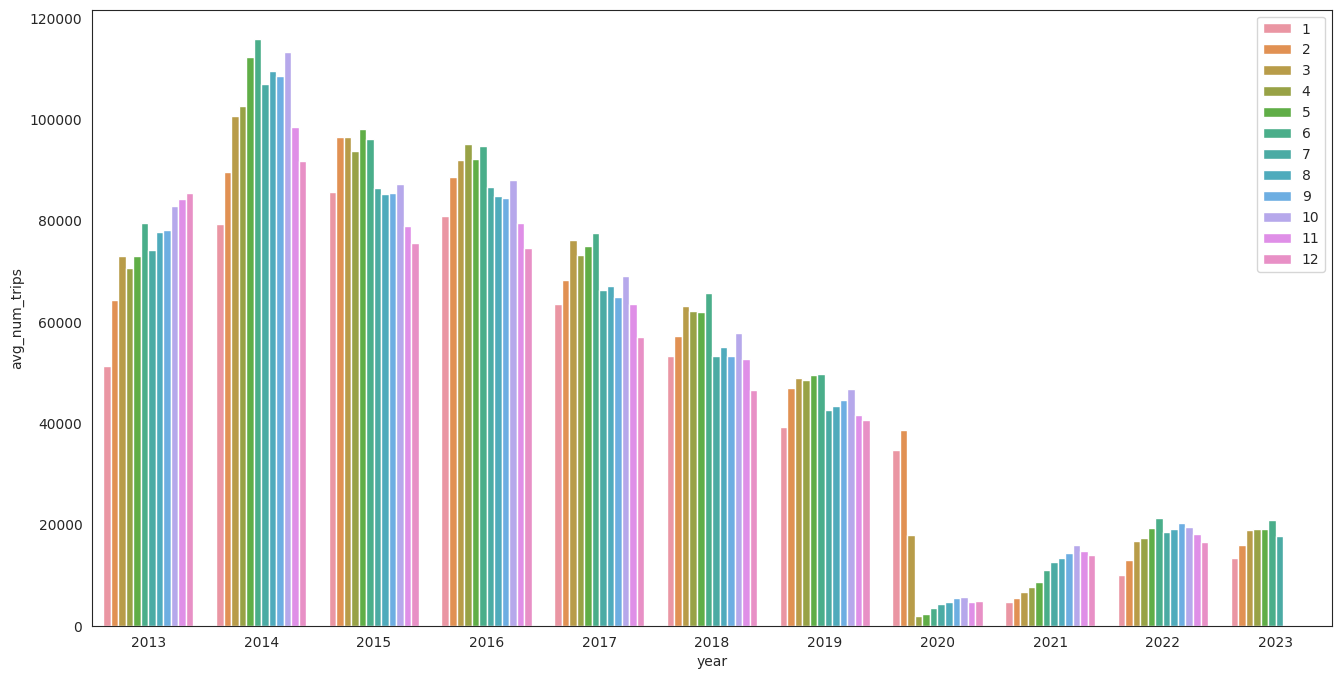

In [106]:
sns.set_style('white')
sns.set_palette('Blues')
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot( x=rmresults['year'], y=rmresults['avg_num_trips'], hue=rmresults['month'], ax=ax)
plt.legend(loc='upper right')
plt.show()

In [129]:
max(mresults['num_trips'])

3510853

## in which month num trips are more

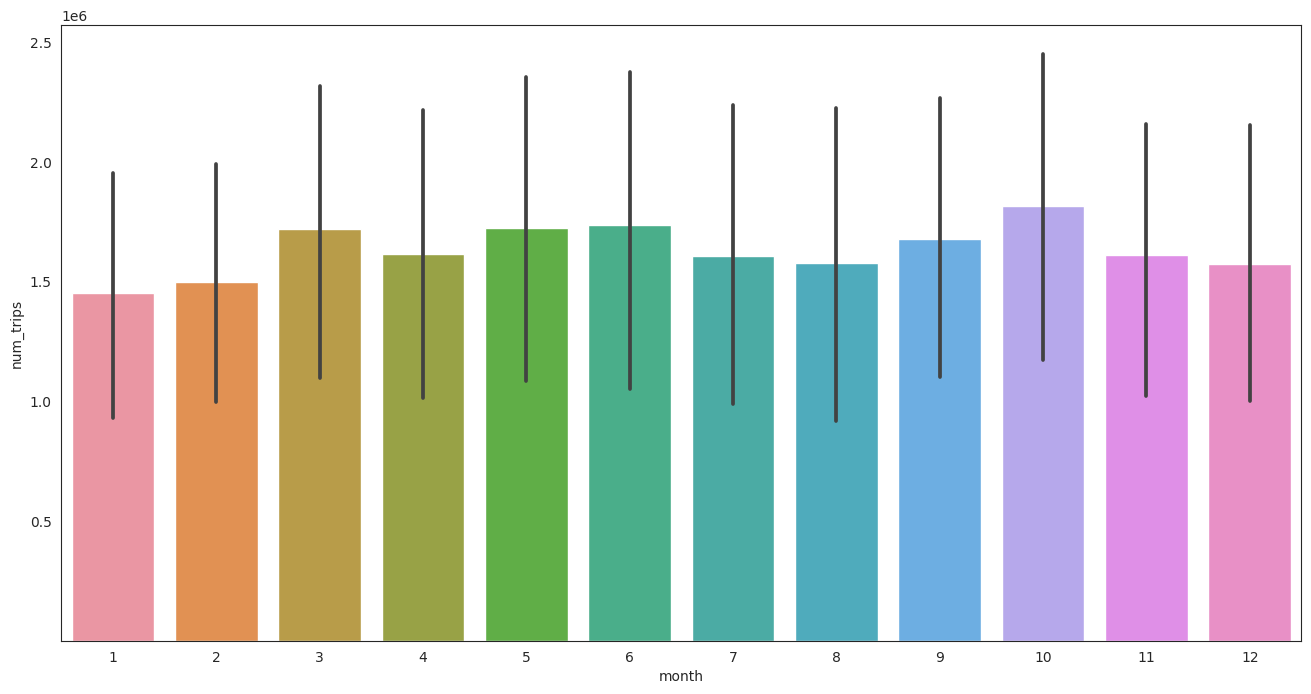

In [128]:
sns.set_style('white')
sns.set_palette('Blues')
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot( x=mresults['month'], y=mresults['num_trips'], ax=ax)
ax.set_ylim(ymin=min(y))
plt.show()

In [133]:
# Relation Between Hour of day and Num of Taxi trips for year 2022
RelevantRides = """
               WITH RelevantRides AS
               (
                   SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, 
                          trip_miles, 
                          trip_seconds
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE trip_start_timestamp > '2021-12-31' AND 
                         trip_start_timestamp < '2023-01-01' AND 
                         trip_seconds > 0 AND 
                         trip_miles > 0
               )
               SELECT hour_of_day, 
                      COUNT(1) AS num_trips, 
                      3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
               FROM RelevantRides
               GROUP BY hour_of_day
               ORDER BY hour_of_day
               """

safeconfig = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

rrresults = client.query(RelevantRides, job_config=safeconfig).to_dataframe()

rrresults

,hour_of_day,num_trips,avg_mph
0,0,112690,24.588165
1,1,74375,23.020938
2,2,43425,22.563536
3,3,30023,26.656161
4,4,32346,31.718683
5,5,52050,33.054452
6,6,95993,28.051443
7,7,170005,21.743665
8,8,249025,19.610448
9,9,281751,21.097607


Text(0.5, 0, 'Hour Of Day')

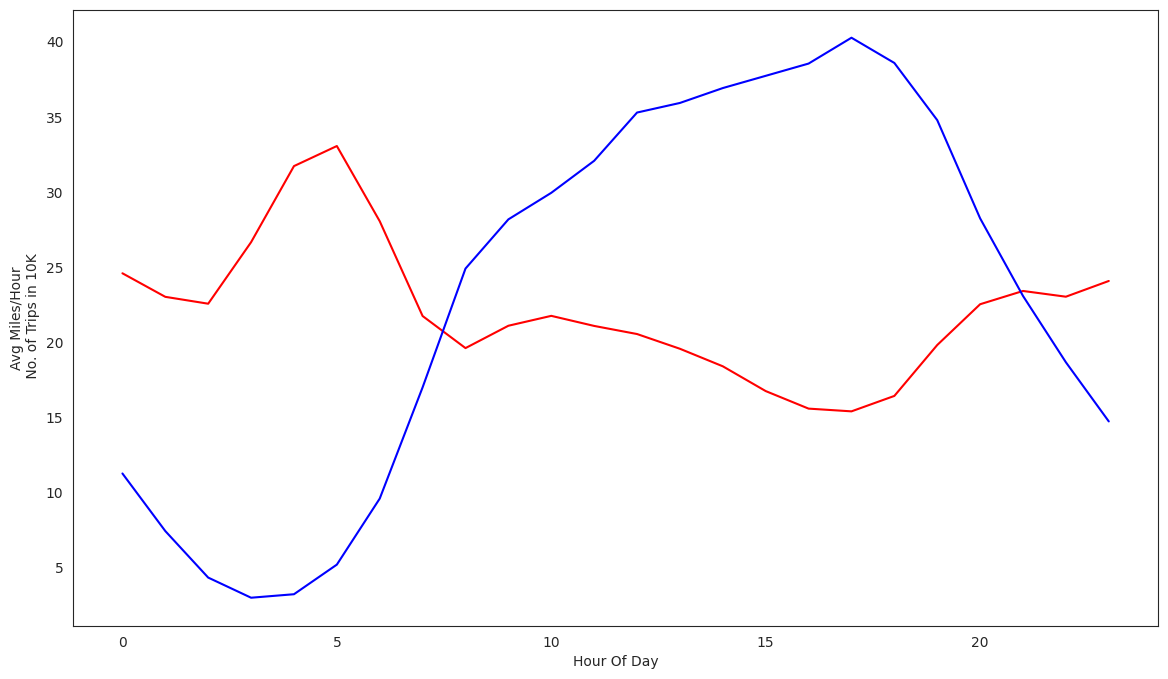

In [150]:
rrresults['num_trips_in_10K']=rrresults['num_trips']/10000

y=rrresults['avg_mph']
x=rrresults['hour_of_day']

y2=rrresults['num_trips_in_10K']
x2=rrresults['hour_of_day']
plt.figure(figsize=(14,8))

plt.plot(x,y,label='Avg Miles/hour',color='r')
plt.plot(x2,y2,label=' No. of Trips in 10K', color='b')
plt.ylabel("Avg Miles/Hour\n No. of Trips in 10K") 
plt.xlabel("Hour Of Day") 
